<a href="https://colab.research.google.com/github/brunatoloti/data-science-do-zero/blob/main/Minera%C3%A7%C3%A3o%20de%20Textos%20e%20NLP/mineracao_textos7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Análise de Sentimentos usando Machine Learning

*   Criaremos modelos para análise de sentimentos de tweets. Usaremos uma base de dados de tweets sobre o governo de Minas Gerais, disponibilizada no curso de Data Science do Zero do Minerando Dados.
*   Essa base de dados disponibilizada possui uma coluna de classificação do sentimento do tweet. Pode ser Neutro, Positivo ou Negativo. Essa classificação foi feita de forma manual por alguma(s) pessoa(s).
*   Faremos teste com modelo usando tag de negações.
*   Faremos teste com modelo usando Bigrams.

**Importando as bibliotecas**

In [1]:
import nltk
from nltk import word_tokenize
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
import seaborn as sns
import matplotlib.pyplot as plt

**Carregando e lendo a base de dados**

In [2]:
dataset = pd.read_csv('/content/drive/MyDrive/Curso Data Science do Zero/Mineração de Textos e NLP/dados/Tweets_Mg.csv', encoding='utf-8')

In [3]:
dataset.head(2)

,Unnamed: 0,Created At,Text,Geo Coordinates.latitude,Geo Coordinates.longitude,User Location,Username,User Screen Name,Retweet Count,Classificacao,Observação,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,0,Sun Jan 08 01:22:05 +0000 2017,���⛪ @ Catedral de Santo Antônio - Governador ...,NaN,NaN,Brasil,Leonardo C Schneider,LeoCSchneider,0,Neutro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Sun Jan 08 01:49:01 +0000 2017,"� @ Governador Valadares, Minas Gerais https:/...",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
dataset.shape

(8199, 26)

**Imprimindo os 50 primeiros tweets desse dataset**

Lembrando que os tweets ficam na coluna *Text* nesse dataset.

In [5]:
dataset.Text.head(50)

0     ���⛪ @ Catedral de Santo Antônio - Governador ...
1     � @ Governador Valadares, Minas Gerais https:/...
2     �� @ Governador Valadares, Minas Gerais https:...
3                           ��� https://t.co/BnDsO34qK0
4     ��� PSOL vai questionar aumento de vereadores ...
5     " bom é bandido morto"\nDeputado Cabo Júlio é ...
6     "..E 25% dos mineiros dizem não torcer para ti...
7     "A gigantesca barba do mal" em destaque no cad...
8     "BB e governo de Minas travam disputa sobre de...
9     "com vcs bh fica pequena!" Belo Horizonte (pro...
10    "Daí a gente visita governador valadares"\n"Qu...
11    "É bonita e é bonita..." \n#latergram #ibituru...
12    "erro desconhecido" é mato! Aliás, é da secret...
13    "La La Land: Cantando Estações" arrasa no Glob...
14    "La La Land: Cantando Estações" arrasa no Glob...
15    "Los abusos, aun en el estado más sólido, son ...
16    "Mesmo sem muito dinheiro no caixa o governo d...
17    "Modelo de segurança será o nosso legado",

**Obtendo a quantidade de linhas de tweets neutros, positivos e negativos**

Quantidade de tweets neutros

In [6]:
dataset[dataset.Classificacao == 'Neutro'].count().Text

2453

Quantidade de tweets positivos

In [7]:
dataset[dataset.Classificacao == 'Positivo'].count().Text

3300

Quantidade de tweets negativos

In [8]:
dataset[dataset.Classificacao == 'Negativo'].count().Text

2446

Visualizando graficamente

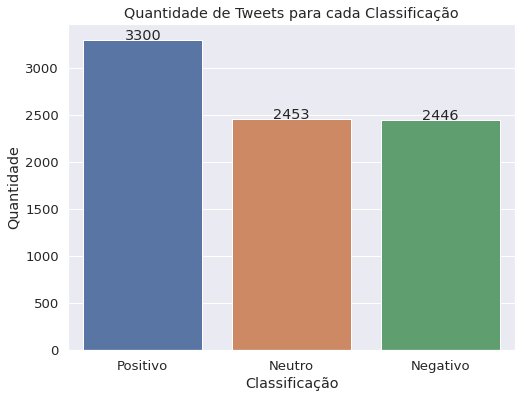

In [9]:
sns.set(font_scale=1.2)     #Definindo o tamanho da fonte

plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Classificacao', data=dataset, order=dataset.Classificacao.value_counts().index)
ax.set_title('Quantidade de Tweets para cada Classificação')
ax.set(xlabel='Classificação', ylabel='Quantidade')  #Definindo os labels do eixo x e y

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

plt.show()

###Pré-processamento dos dados

*   Removeremos possíveis linhas duplicadas na base de dados.
*   Removeremos StopWords.
*   Faremos Stemming nos dados.
*   Removeremos caracteres indesejados como pontuação e removeremos links.

**Removendo linhas duplicadas na base de dados**

In [10]:
dataset.drop_duplicates(subset=['Text'], inplace=True)

In [11]:
dataset.shape

(5765, 26)

Observe que de 8199 tweets, agora temos 5765 tweets.

**Separando dados de tweets das suas classes**

In [12]:
tweets = dataset.Text
classes = dataset.Classificacao

**Instalando a biblioteca nltk e importando os pacotes**

In [13]:
import nltk
nltk.download('stopwords')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


True

**Criando funções para alguns pré-processamentos**


Remoção de StopWords

In [14]:
def RemoveStopWords(sentence):
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    words = [i for i in sentence.split() if not i in stopwords]
    return (' '.join(words))

Stemming

In [15]:
def Stemming(sentence):
    stemmer = nltk.stem.RSLPStemmer()
    words = []
    for w in sentence.split():
        words.append(stemmer.stem(w))
    return (' '.join(words))

Limpeza dos Dados

*   Remoção de:
    *   links;
    *   pontuação.

In [20]:
import string

In [21]:
def DataCleaning(sentence):
    exclude = set(string.punctuation)
    sentence = re.sub(r'http\S+', '', sentence).lower()
    sentence = ''.join(ch for ch in sentence if ch not in exclude)
    return (sentence)

**Aplicando algumas frases a essas funções para entender o funcionamento delas**

In [22]:
RemoveStopWords('Eu não gosto do partido e, também, não votaria novamente nesse governante!')

'Eu gosto partido e, também, votaria novamente nesse governante!'

Esse caso aqui do RemoveStopWords não nos ajudaria se quiséssemos manter o sentido da frase. Note que uma das stopwords foi a palavra *'não'*. Com ela sendo removida da frase, o sentido da sentença ficou diferente! Será que é interessante usar essas stopwords no nosso problema de análise de sentimentos? Pode não ser muito bom!

Lembrando que aqui estamos usando as stopwords da biblioteca da nltk. Se necessário,  podemos criar nosso próprio conjunto de stopwords, dependendo do nosso problema.

In [23]:
Stemming('Eu não gosto do partido e, também, não votaria novamente nesse governante!')

'eu não gost do part e, também, não vot nov ness governante!'

Lembrando que o método de Stemming reduz algumas palavras ao seu radical. Mas, nem sempre é a melhor solução usar esse método. Observe neste exemplo que a palavra *'gosto'* virou *'gost'*, porém *'gost'* é uma palavra que não existe, não tem sentido.

Isso pode ser um erro do método de Stemming utilizado e pode ser que em uma tarefa de análise de sentimentos esse método não seja interessante.

In [24]:
DataCleaning('Assista aqui o vídeo do Governador falando sobre a CEMIG https://www.uol.com.br :) ;)')

'assista aqui o vídeo do governador falando sobre a cemig   '

Precisamos analisar se faz sentido usarmos esses métodos de pré-processamento. Podemos optar por não usar algum ou não usar nenhum dos métodos. Note que eles podem não ajudar em todos os casos, logo, dependendo do nosso problema, é melhor não utilizar.

**Aplicando apenas o método DataCleaning nos dados de tweets**

Dado o resultado obtido com os outros métodos, acredito que o único que vale a pena utilizar aqui, no nosso caso de análise de sentimentos, seja o método de limpeza de pontos e links. Portanto, os outros dois métodos serão ignorados, nesse caso.

In [25]:
tweets = [DataCleaning(i) for i in tweets]

**Visualizando os 50 primeiros tweets com o método aplicado**

In [26]:
tweets[:50]

['���⛪  catedral de santo antônio  governador valadaresmg ',
 '�  governador valadares minas gerais ',
 '��  governador valadares minas gerais ',
 '��� ',
 '��� psol vai questionar aumento de vereadores e prefeito de bh na justiça  politica  estado de minas ',
 ' bom é bandido morto\ndeputado cabo júlio é condenado e fica inelegível por 10 anos  politica  estado de minas ',
 'e 25 dos mineiros dizem não torcer para time nenhummesmo dentro de um estado com atléticomg e cruzeiro pq ',
 'a gigantesca barba do mal em destaque no caderno cultura do estado de minas ',
 'bb e governo de minas travam disputa sobre depósitos judiciais ',
 'com vcs bh fica pequena belo horizonte pron bɛloɾiˈzõntʃi10 é a capital do estado de mg com uma área de aproximadamente 331 km²',
 'daí a gente visita governador valadares\nque lugar eh esse mãe\nmg a gente tem uns parente la\n\nmano onde q eu não tenho parente',
 'é bonita e é bonita \nlatergram ibituruna home  governador valadares minas gerais ',
 'erro des

###Criando o modelo

**Instanciando o objeto que faz a vetorização dos dados de texto**

Geralmente, modelos de Machine Learning não se saem muito bem com dados de texto. Por isso, precisamos processar esses textos e transformá-los em  vetores numéricos. Dessa forma, usamos os vetores nos modelos de Machine Learning.

In [27]:
vectorizer = CountVectorizer(analyzer='word')

**Aplicando o vetorizador nos dados de texto**

In [28]:
freq_tweets = vectorizer.fit_transform(tweets)
type(freq_tweets)

scipy.sparse.csr.csr_matrix

Ou seja, freq_tweets é uma matriz esparsa.

In [29]:
freq_tweets.A

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

**Visualizando o número de linhas e colunas da matriz**

In [30]:
freq_tweets.shape

(5765, 7248)

Cada palavra é uma coluna da matriz.

**Instanciando o modelo Naive Bayes Multinomial**

Classificador muito utilizado em análise de sentimentos

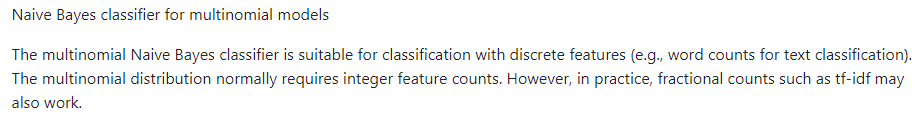

In [31]:
model = MultinomialNB()
model.fit(freq_tweets, classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

**Testando o modelo com algumas instâncias simples**

Sentenças usadas na aula do curso Data Science do Zero do Minerando Dados.

In [32]:
tests = ['Esse governo está no início, vamos ver o que vai dar',
         'Estou muito feliz com o governo de Minas esse ano',
         'O estado de Minas Gerais decretou calamidade financeira!!!',
         'A segurança desse país está deixando a desejar',
         'O governador de Minas é mais uma vez do PT']

Aplicando a função de Data Cleaning nos dados de teste

In [33]:
tests = [DataCleaning(i) for i in tests]

Vetorizando os dados de teste

In [34]:
freq_tests = vectorizer.transform(tests)

Fazendo a classificação dos dados de teste com o modelo treinado

In [35]:
for t, c in zip(tests, model.predict(freq_tests)):
    print(t +" - "+ c)

esse governo está no início vamos ver o que vai dar - Neutro
estou muito feliz com o governo de minas esse ano - Neutro
o estado de minas gerais decretou calamidade financeira - Negativo
a segurança desse país está deixando a desejar - Neutro
o governador de minas é mais uma vez do pt - Neutro


Observe que a segunda sentença e a quarta sentença foram classificadas de forma errada. A segunda deveria ser classificada como positiva e a quarta deveria ser classificada como negativa, mas ambas foram classificadas como neutras.

Vejamos a probabilidade de classificação de cada classe para cada uma dessas sentenças de teste

In [36]:
print(model.classes_)
model.predict_proba(freq_tests).round(2)

['Negativo' 'Neutro' 'Positivo']


array([[0.29, 0.71, 0.  ],
       [0.04, 0.96, 0.  ],
       [0.99, 0.01, 0.  ],
       [0.12, 0.86, 0.02],
       [0.22, 0.78, 0.  ]])

Essa não é a melhor forma de validar o modelo. Isso foi apenas um teste. Uma melhor validação será feita posteriormente.

Mas, antes disso, vamos ver como funciona a função de tags de negações.

###Função de Tags de Negações

*   Acrescenta uma tag _NEG em todas as palavras após um *'não'*.
*   O objetivo é dar mais peso para o modelo identificar uma inversão de sentimento na frase.
*   Exemplos:
    *   Eu gosto de cachorros - Positivo
    *   Eu não gosto de cachorros - Negativo

In [40]:
def set_neg(text):
    neg = ['não', 'not']
    neg_detected = False
    result = []
    exclude = set(string.punctuation)
    text = ''.join(ch for ch in text if ch not in exclude)
    words = text.split()
    for w in words:
        w = w.lower()
        if neg_detected == True:
            w = w + '_NEG'
        if w in neg:
            neg_detected = True
        result.append(w)
    return (' '.join(result))

**Usando algumas frases de exemplo para vermos o funcionamento dessa função**

In [41]:
set_neg('Eu gosto do partido, votaria novamente nesse governante!')

'eu gosto do partido votaria novamente nesse governante'

Observe que, como não há palavras da lista *neg* nessa frase, ou seja, não há *não* nessa frase, não houve mudança em nenhuma palavra.

In [42]:
set_neg('Eu não gosto do partido, não votaria novamente nesse governante!')

'eu não gosto_NEG do_NEG partido_NEG não_NEG votaria_NEG novamente_NEG nesse_NEG governante_NEG'

Observe que, como há *'não'* nessa frase, foi acrescentada a tag _NEG em todas as palavras após a palavra *'não'*.

###Criando modelos com Pipelines

*   Pipelines são interessantes para reduzir código e automatizar fluxos
*   A classe Pipeline nos permite embutir no modelo não apenas o algoritmo usado, mas também a forma como ele irá pré-processar os dados.

Mais informações no artigo nesse [link](https://medium.com/data-hackers/como-usar-pipelines-no-scikit-learn-1398a4cc6ae9).

**Importando a biblioteca**

In [43]:
from sklearn.pipeline import Pipeline

**Criando um pipeline**

*   Primeiro passo desse Pipeline é vetorizar os dados.
*   Segundo passo desse Pipeline é criar um classificador Naive Bayes Multinomial.

In [45]:
simple_pipeline = Pipeline([
    ('counts', CountVectorizer()),
    ('classifier', MultinomialNB())
])

**Criando um outro pipeline que usa tag de negações**

*   Primeiro passo desse Pipeline é vetorizar os dados, usando tag de negações.
*   Segundo passo desse Pipeline é criar um classificador Naive Bayes Multinomial.

In [44]:
neg_pipeline = Pipeline([
    ('counts', CountVectorizer(tokenizer = lambda text: set_neg(text))),
    ('classifier', MultinomialNB())
])

Vejamos como cada pipeline performa.

**Treinando os modelos**

simple_pipeline

In [47]:
simple_pipeline.fit(tweets, classes)

Pipeline(memory=None,
         steps=[('counts',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [48]:
simple_pipeline.steps

[('counts',
  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                  dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                  lowercase=True, max_df=1.0, max_features=None, min_df=1,
                  ngram_range=(1, 1), preprocessor=None, stop_words=None,
                  strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                  tokenizer=None, vocabulary=None)),
 ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]

neg_pipeline

In [49]:
neg_pipeline.fit(tweets, classes)

Pipeline(memory=None,
         steps=[('counts',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function <lambda> at 0x7f75bb5c4710>,
                                 vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [50]:
neg_pipeline.steps

[('counts',
  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                  dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                  lowercase=True, max_df=1.0, max_features=None, min_df=1,
                  ngram_range=(1, 1), preprocessor=None, stop_words=None,
                  strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                  tokenizer=<function <lambda> at 0x7f75bb5c4710>,
                  vocabulary=None)),
 ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]

**Validando o modelo simples com Validação Cruzada**

Fazendo o cross validation do modelo

In [51]:
results_simple = cross_val_predict(simple_pipeline, tweets, classes, cv=10)

Medindo a acurácia média do modelo

In [52]:
metrics.accuracy_score(classes, results_simple)

0.8679965307892454

Obtendo medidas de validação do modelo

In [53]:
c = ['Positivo', 'Negativo', 'Neutro']
print(metrics.classification_report(classes, results_simple, c))

              precision    recall  f1-score   support

    Positivo       0.96      0.88      0.92      2840
    Negativo       0.77      0.89      0.83       951
      Neutro       0.81      0.84      0.82      1974

    accuracy                           0.87      5765
   macro avg       0.85      0.87      0.86      5765
weighted avg       0.87      0.87      0.87      5765



Obtendo a matriz de confusão

In [54]:
pd.crosstab(classes, results_simple, rownames=['Real'], colnames=['Predito'], margins=True)

Predito,Negativo,Neutro,Positivo,All
Real,,,,
Negativo,846,100,5,951
Neutro,202,1665,107,1974
Positivo,45,302,2493,2840
All,1093,2067,2605,5765


**Validando o modelo com tag de negações com Validação Cruzada**

Fazendo o cross validation do modelo

In [55]:
results_neg = cross_val_predict(neg_pipeline, tweets, classes, cv=10)

Medindo a acurácia média do modelo

In [57]:
metrics.accuracy_score(classes, results_neg)

0.6617519514310495

Obtendo medidas de validação do modelo

In [58]:
c = ['Positivo', 'Negativo', 'Neutro']
print(metrics.classification_report(classes, results_neg, c))

              precision    recall  f1-score   support

    Positivo       0.64      0.90      0.75      2840
    Negativo       0.68      0.36      0.47       951
      Neutro       0.71      0.47      0.56      1974

    accuracy                           0.66      5765
   macro avg       0.68      0.57      0.59      5765
weighted avg       0.67      0.66      0.64      5765



Obtendo a matriz de confusão

In [59]:
pd.crosstab(classes, results_neg, rownames=['Real'], colnames=['Predito'], margins=True)

Predito,Negativo,Neutro,Positivo,All
Real,,,,
Negativo,341,178,432,951
Neutro,78,919,977,1974
Positivo,86,199,2555,2840
All,505,1296,3964,5765


Observe que o modelo que utiliza tag de negações se saiu pior do que o modelo simples. Portanto, para esse caso, para esses dados, atribuir tag de negações não é a melhor saída.

**Testando e avaliando modelo com Unigrams e Bigrams**

In [75]:
vectorizer = CountVectorizer(ngram_range=(1,2))
freq_tweets = vectorizer.fit_transform(tweets)
model = MultinomialNB()
model.fit(freq_tweets, classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [76]:
results = cross_val_predict(model, freq_tweets, classes, cv=10)

In [77]:
metrics.accuracy_score(classes, results)

0.8638334778837814

In [78]:
c = ['Positivo', 'Negativo', 'Neutro']
print(metrics.classification_report(classes, results, c))

              precision    recall  f1-score   support

    Positivo       0.97      0.88      0.92      2840
    Negativo       0.67      0.93      0.78       951
      Neutro       0.86      0.81      0.83      1974

    accuracy                           0.86      5765
   macro avg       0.83      0.87      0.84      5765
weighted avg       0.88      0.86      0.87      5765



In [79]:
pd.crosstab(classes, results, rownames=['Real'], colnames=['Predito'], margins=True)

Predito,Negativo,Neutro,Positivo,All
Real,,,,
Negativo,889,62,0,951
Neutro,292,1606,76,1974
Positivo,148,207,2485,2840
All,1329,1875,2561,5765


Observe que usando Unigrams e Bigrams na vetorização, teve um desempenho similar ao modelo simples que fizemos anteriormente.

**Considerações finais**

*   Aumentar a quantidade de dados de treino pode ser bom para melhorar os resultados.
*   Da mesma forma, alterar os parâmetros do algoritmo pode melhorar o desempenho do modelo.
*   Deve-se fazer vários testes fazendo alterações em parâmetros e quantidade de dados.